# Detección de cubrebocas

In [1]:
import os
import cv2
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, Model
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from time import time
%load_ext tensorboard

### Ajustando espacio de trabajo y asignando constantes

In [2]:
PATH = os.getcwd()
DATASET_DIR = os.path.join(PATH, "dataset")
LABELS = ['WithoutMask', 'WithMask']
TRAIN_DIR = os.path.join(DATASET_DIR, 'Train')
TEST_DIR = os.path.join(DATASET_DIR, 'Test')
VALIDATION_DIR = os.path.join(DATASET_DIR, 'Validation')
OWN_DATA_DIR = os.path.join(DATASET_DIR, 'own')
SPLT_DIRS = [TRAIN_DIR, TEST_DIR, VALIDATION_DIR]

### Construyendo datasets

In [3]:
image_size = (180, 180)
image_shape = image_size + (3,)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VALIDATION_DIR,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


### Visualizando los datos

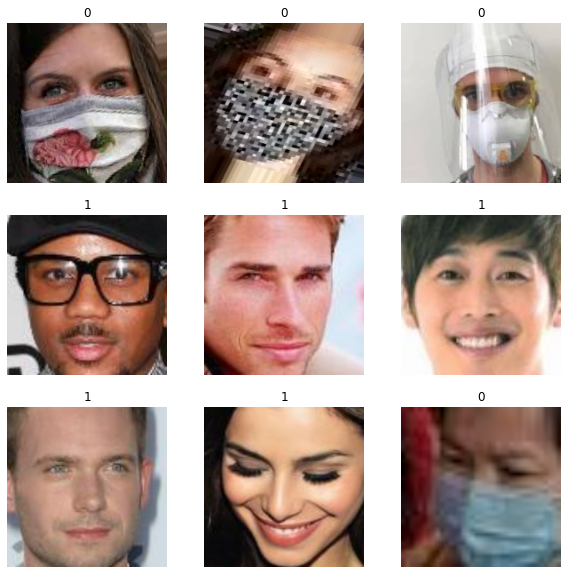

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Configurando los datasets para un mejor desempeño

In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### Construyendo el modelo

In [6]:
def make_model(input_shape):
    inputs = Input(shape=input_shape)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return Model(inputs, outputs)


model = make_model(input_shape=image_shape)

### Entrenando el modelo

In [7]:
epochs = 5
tensorboard_dir = os.path.join(PATH, 'logs', str(time()))
callbacks = [
    ModelCheckpoint("save_at_{epoch}.h5"),
    TensorBoard(log_dir=tensorboard_dir)
]
model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
  1/313 [..............................] - ETA: 0s - loss: 0.9092 - accuracy: 0.4688WARNING:tensorflow:From /Users/dcordova/.virtualenvs/mask/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
313/313 [==============================] - 1560s 5s/step - loss: 0.1240 - accuracy: 0.9533 - val_loss: 0.6659 - val_accuracy: 0.5113
Epoch 2/5
313/313 [==============================] - 1307s 4s/step - loss: 0.0476 - accuracy: 0.9837 - val_loss: 0.1067 - val_accuracy: 0.9700
Epoch 3/5
313/313 [==============================] - 1279s 4s/step - loss: 0.0404 - accuracy: 0.9852 - val_loss: 0.0386 - val_accuracy: 0.9850
Epoch 4/5
313/313 [==============================] - 1248s 4s/step - loss: 0.0327 - accuracy: 0.9882 - val_loss: 0.0701 - val_accuracy: 0.9750
Epoch 5/5
313/313 [========================

### Tensorboard

In [9]:
%tensorboard --logdir={tensorboard_dir}

### Validación cruzada

In [10]:
test = model.evaluate(test_ds)

31/31 [==============================] - 32s 1s/step - loss: 0.0335 - accuracy: 0.9879


### Probando con nuestros propios datos

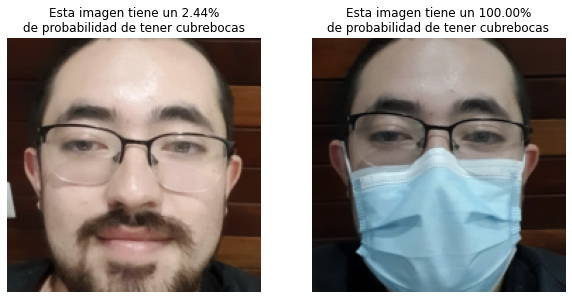

In [12]:
image_path_without = os.path.join(OWN_DATA_DIR, "WithoutMask", "without.png")
image_path_with = os.path.join(OWN_DATA_DIR, "WithMask", "with.png")
paths = [image_path_without, image_path_with]
plt.figure(figsize=(10, 5))
for i, path in enumerate(paths):
    ax = plt.subplot(1, 2, i + 1)
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.3,
            minNeighbors=3,
            minSize=(30, 30)
    )
    x, y, w, h = faces[0]
    image = image[y:y+h, x:x+w]
    resized = cv2.resize(image, image_size, interpolation = cv2.INTER_AREA)
    new_image = resized[:, :,[2,1,0]]
    input_arr = np.array([new_image], dtype="uint8")
    predictions = model.predict(input_arr)
    score = (1 - predictions[0][0]) * 100
    plt.title(f"Esta imagen tiene un {score:.2f}%\nde probabilidad de tener cubrebocas")
    plt.imshow(input_arr[0])
    plt.axis("off")
plt.show()

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 32)   128         conv2d[0][0]                     
_______________________________________________________________________________________